Install pickle maybe

change path to poisson solver

in compare with fenics part: change directory for the import of the parameters and Cq / Gq matrices

In [1]:
class Unit_converter(object):
    '''
    UPDATE FROM MAY 2017 After verification of conversions
    A simple class that allows communication between Kwant space,
    Poisson space and the real units

    THE SPIN IS INCLUDED

    conventions: 
        real space: no suffix: n, U
        quantum space (kwant): q suffix: nq, Uq, Gq
        poisson space: bar suffix: nbar, Ubar, Gbar
        
    note: True for chris'like geometry
    '''

    def __init__(self, aq, ap, eps_r, mstar_over_me):

        self.aq = aq
        self.ap = ap
        self.eps_r = eps_r
        self.mstar_over_me = mstar_over_me

        #physical constants
        self.eps0 = 8.854187817e-12  # F/m
        self.e = 1.60217662e-19  # C >0
        self.hbar = 1.0545718e-34  # J/s
        self.me = 9.10938356e-31 # kg

        # problem constants
        self.mstar = mstar_over_me * self.me
        self.eps = self.eps0 * self.eps_r
        print(self.eps)
        self.abohr = 4. * np.pi * self.eps * self.hbar**2 / (self.mstar * self.e**2) # m

        self.t = self.hbar**2 / (2 * self.mstar * aq**2)

        # G^q = kappa \bar{G}
        self.kappa = 8. * np.pi * ap / self.abohr 

    # test
    def test(self, val, eps=1.e-17):
        assert abs(val - self.U_to_Ubar(self.Ubar_to_Uq(self.Uq_to_U(val)))) < eps, 'failed U -> Ubar -> Uq -> U, {}'.format(abs(val - self.U_to_Ubar(self.Ubar_to_Uq(self.Uq_to_U(val)))))
        assert abs(val - self.U_to_Uq(self.Uq_to_Ubar(self.Ubar_to_U(val)))) < eps, 'failed U -> Uq -> Ubar -> U, {}'.format(abs(val - self.U_to_Uq(self.Uq_to_Ubar(self.Ubar_to_U(val)))))
        assert abs(val - self.n_to_nbar(self.nbar_to_nq(self.nq_to_n(val)))) < eps, 'failed n -> nbar -> nq -> n, {}'.format(abs(val - self.n_to_nbar(self.nbar_to_nq(self.nq_to_n(val)))))
        assert abs(val - self.n_to_nq(self.nq_to_nbar(self.nbar_to_n(val)))) < eps, 'failed n -> nq -> nbar -> n, {}'.format(abs(val - self.n_to_nq(self.nq_to_nbar(self.nbar_to_n(val)))))
        assert abs(val - self.Gbar_to_Gq(self.Gq_to_Gbar(val))) < eps, 'failed Gbar -> Gq -> Gbar, {}'.format(abs(val - self.Gbar_to_Gq(self.Gq_to_Gbar(val))))
        return True

    # real -> quantum
    def n_to_nq(self, n):
        ''' converts the charge density of m^-2 to the nbr of charge per kwant site'''
        return self.aq**2 * n

    def U_to_Uq(self, U):
        ''' converts potential in volts to the potential used by kwant'''
        return -self.e / self.t * U

    # quantum -> real
    def nq_to_n(self, nq):
        ''' converts kwant density to the charge density in m^-2 '''
        return nq / self.aq**2

    def Uq_to_U(self, Uq):
        ''' converts kwant potential to the potential in Volt'''
        return -self.t / self.e * Uq

    # real -> poisson
    def n_to_nbar(self, n):
        ''' converts charge density of in m^-2 to poisson density'''
        return n * self.ap**2

    def U_to_Ubar(self, U, epsr=None):
        ''' converts a potential poisson to a real potential in volt'''
        if epsr is not None:
            tmp = -(self.eps0 * epsr * self.ap) / self.e
        else:
            tmp = -(self.eps * self.ap) / self.e
        return tmp * U

    # poisson -> real
    def nbar_to_n(self, nbar):
        ''' converts poisson density to the charge density of in m^-2'''
        return nbar / self.ap**2

    def Ubar_to_U(self, Ubar, epsr=None):
        ''' converts a potential poisson to a real potential in volt'''
        if epsr is not None:
            tmp = -self.e / (self.eps0 * epsr * self.ap)
        else:
            tmp = -self.e / (self.eps * self.ap)
        return tmp * Ubar

    # quantum -> poisson
    def nq_to_nbar(self, nq):
        ''' converts kwant density to poisson density'''
        return self.ap**2 / self.aq**2 * nq

    def Uq_to_Ubar(self, Uq, epsr=None):
        ''' converts a potential kwant to a potential poisson'''
        if epsr is not None:
            tmp = (self.eps0 * epsr)
        else:
            tmp = self.eps
        return self.t * tmp * self.ap / self.e**2 * Uq

    def Gq_to_Gbar(self, Gq):
        ''' converts the kwant greens matrix to the poisson greens'''
        return 1. / self.kappa * Gq

    # poisson -> quantum
    def nbar_to_nq(self, nbar):
        ''' converts kwant density to poisson density'''
        return self.aq**2 / self.ap**2 * nbar

    def Ubar_to_Uq(self, Ubar, epsr=None):
        ''' converts a potential poisson to a potential kwant'''
        if epsr is not None:
            tmp = (self.eps0 * epsr)
        else:
            tmp = self.eps
        return self.e**2 / (self.t * tmp * self.ap) * Ubar

    def Gbar_to_Gq(self, Gbar):
        ''' converts the kwant greens matrix to the poisson greens'''
        return self.kappa * Gbar
    
from collections import namedtuple
self_consistency = namedtuple('dummy', 'Unit_converter')
self_consistency.Unit_converter = Unit_converter

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import voronoi_plot_2d, Voronoi

from poisson import plot as p_plt
from poisson.continuous import shapes
from poisson.tools import post_process
from poisson import (DiscretePoisson, GridBuilder, ContinuousGeometry,
                     LinearProblem)
#import self_consistency

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [3]:
######### PHYSICAL PROBLEM #########
nm = 1.e-9
W_between_gates = 1000. * nm
gates_W = 300. * nm
gates_h = 120. * nm
AlGaAs_h = 140. * nm

gas_h = 10.* nm # cond-mat/0403191
gas_z = -5 * nm

eps_r = 12
mstar_over_me = 0.067

######### INIT POISSON SIMU #########
a_poisson = 1 * nm

# size of the box
L = 2.e-6

#number of kwant sites
Nkwant = 301

def make_geom(out_xmin, out_xmax, 
              out_ymin=-1.5 * (AlGaAs_h + gates_h),
              out_ymax=2 * (AlGaAs_h + gates_h)):

    out_A = [out_xmin, out_ymin]
    out_B = [out_xmax, out_ymin]
    out_C = [out_xmax, out_ymax]
    out_D = [out_xmin, out_ymax]
    
    in_A = [-(W_between_gates + 4. * gates_W) / 2., -10. * gas_h]
    in_B = [(W_between_gates + 4. * gates_W) / 2., -10. * gas_h]
    in_C = [(W_between_gates + 4. * gates_W) / 2., 10. * gas_h]
    in_D = [-(W_between_gates + 4. * gates_W) / 2., 10. * gas_h]

    gate1_A = [-(gates_W + W_between_gates / 2.), AlGaAs_h]
    gate1_B = [-W_between_gates / 2., AlGaAs_h]
    gate1_C = [-W_between_gates / 2., AlGaAs_h + gates_h]
    gate1_D = [-(gates_W + W_between_gates / 2.), AlGaAs_h + gates_h]

    gate2_A = [W_between_gates / 2., AlGaAs_h]
    gate2_B = [W_between_gates / 2. + gates_W, AlGaAs_h]
    gate2_C = [W_between_gates / 2. + gates_W, AlGaAs_h + gates_h]
    gate2_D = [W_between_gates / 2., AlGaAs_h + gates_h]

    outerbox = np.array([out_A, out_B, out_C, out_D]) / a_poisson
    quantumbox = np.array([in_A, in_B, in_C, in_D]) / a_poisson
    gate1 = np.array([gate1_A, gate1_B, gate1_C, gate1_D]) / a_poisson
    gate2 = np.array([gate2_A, gate2_B, gate2_C, gate2_D]) / a_poisson    

    ######### INIT 'KWANT' PART (orbitals) #########
    
    a_kwant = (W_between_gates + 3. * gates_W) / Nkwant
    sites = np.arange(-(Nkwant - 1) // 2 , (Nkwant - 1 )// 2 + 1) * a_kwant
    
    print('akwant =', a_kwant)

    kwantboxpts = np.sort(np.concatenate((sites, 
                                          [sites[0] - a_kwant], [sites[-1] + a_kwant])))
    kwantboxpts = np.vstack((kwantboxpts, 
                             gas_z * np.ones(len(kwantboxpts)))).T
    vector = np.array([0, 10 * nm])
    kwantboxpts = np.concatenate((kwantboxpts, kwantboxpts - vector, 
                                  kwantboxpts + vector)) / a_poisson
    
    return outerbox, quantumbox, gate1, gate2, kwantboxpts

In [4]:
def make_grid(xm=-L, xM=L, 
              ym=-1.5 * (AlGaAs_h + gates_h),
              yM=2 * (AlGaAs_h + gates_h), ot_a=25, g_a=25, q_a=25, epsr=1):
    
    outer, quantum, gate1, gate2, kwantpts = make_geom(xm, xM, ym, yM)

    eps = 0.01

    outerbbox = [min(outer[:, 0]), max(outer[:, 0]), 
                 min(outer[:, 1]), max(outer[:, 1])]
    kwantbbox = [min(kwantpts[:, 0]) - eps, max(kwantpts[:, 0]) + eps, 
                 min(kwantpts[:, 1]) - eps, max(kwantpts[:, 1]) + eps]

    ots = shapes.Delaunay(outer)
    qs = shapes.Delaunay(quantum)
    g1s = shapes.Delaunay(gate1)
    g2s = shapes.Delaunay(gate2)
    ks = shapes.Rectangle(length=(np.diff(kwantbbox[:2]), np.diff(kwantbbox[2:])),
                          corner=(kwantbbox[0], kwantbbox[2]))

    ### grid thinness
    ot_a = 25
    g_a = 25
    q_a = 25

    grid = GridBuilder(meshs=[[outerbbox, ot_a, ots, 0],
                                     [outerbbox, g_a, g1s, 1],
                                     [outerbbox, g_a, g2s, 2],
                                     [outerbbox, q_a, qs, 3]],
                              holes=[ks], points=[(kwantpts, 4)])
    
    print(str(len(grid.points)) +  ' Grid points')
    
    return grid, ots, qs, g1s, g2s, ks, epsr

In [5]:
def prepare_solver(grid, ots, qs, g1s, g2s, ks, epsr):
   
    poissonpro = ContinuousGeometry(
            space=ots, voltage={'gate1':g1s, 'gate2':g2s}, 
            mixed=[ks], default_relative_permittivity=epsr)

    discretized_obj = DiscretePoisson(poissonpro,
                                      grid=grid,
                                      selection={'Neuman-Dirichlet':[['voltage', '*']]})

    ksites = discretized_obj.points_system_mixed
    ksites = ksites[discretized_obj.mesh.points[ksites][:, 1] == -gas_h / 2 / a_poisson][1:-1]
    return discretized_obj, ksites

# Test Solver

In [6]:
grid, ots, qs, g1s, g2s, ks, epsr = make_grid(epsr=5)
discretized_obj, ksites = prepare_solver(grid, ots, qs, g1s, g2s, ks, epsr)


akwant = 6.312292358803987e-09
6753 Grid points
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
{'Neuman-Dirichlet': [['voltage', '*']]}
Done Neuman - Dirichlet refinement
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


### Plots

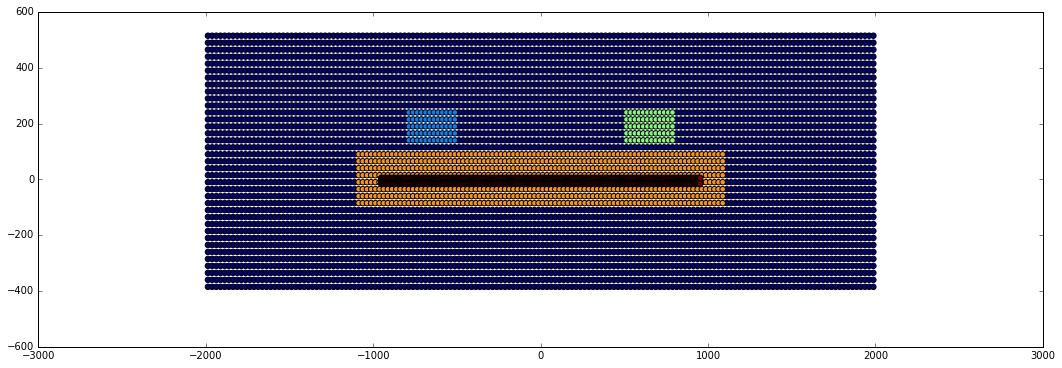

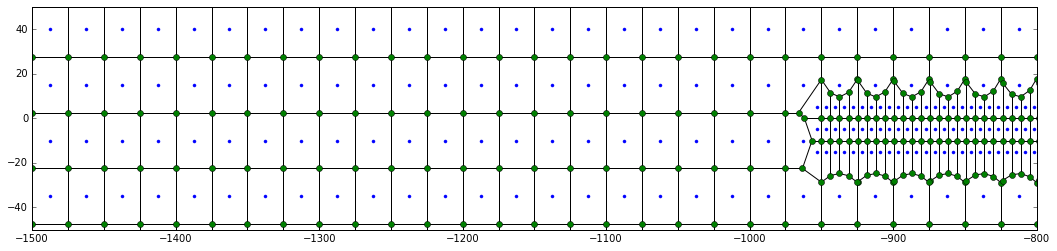

In [7]:
plt.figure(figsize=(18, 6))
plt.scatter(grid.points[:, 0], grid.points[:, 1], c=grid.point_label, s=30)
plt.show()

f, ax = plt.subplots(1, figsize=(18, 4))
voronoi_plot_2d(discretized_obj.mesh.voronoi_obj, ax=ax)
plt.xlim(-1500, -800)
plt.ylim(-50, 50)
plt.show()

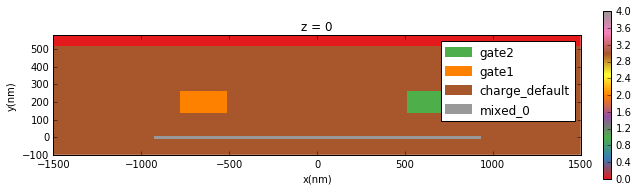

In [8]:
ppp = discretized_obj.geometry.plot(direction=2, bbox=[-1500, 1500, -100, 580])
img, ax, colorbar = ppp(variable=0)
colorbar.remove()
plt.colorbar(img, fraction = 0.015, pad = 0.04)
plt.show()

In [9]:
%%capture
system_eq_obj = LinearProblem(discretized_obj, 
                              is_charge_density=False,
                              voltage_val = [(g1s + g2s, .0)], 
                              pos_voltage_mixed=ksites, mixed_val=[(ksites, 1)])

In [10]:
fvolt, fchar = system_eq_obj.plot_cut_2d(direction=(2))
img, ax, colorbar = fvolt(0, cmap='viridis');
colorbar.remove()
plt.colorbar(img, fraction = 0.015, pad = 0.04)

{'label': 'charge', 'ls': 'none', 'marker': 'o'}


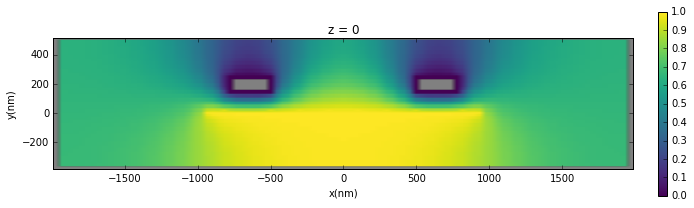

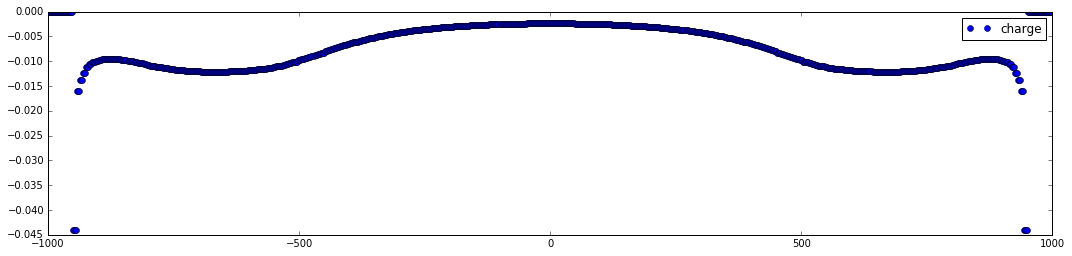

{'label': 'voltage', 'ls': 'none', 'marker': 'o'}


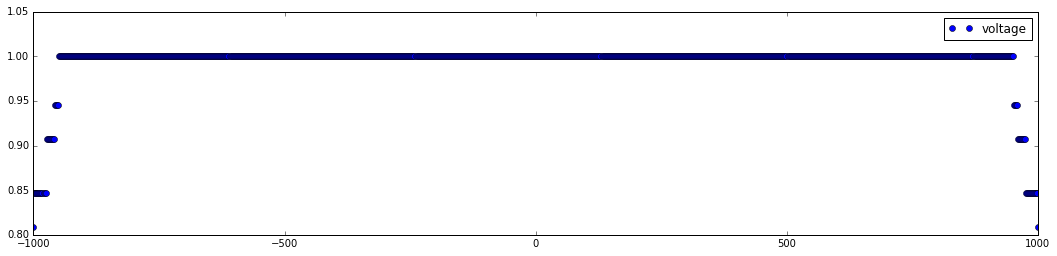

In [11]:
fffcharge = system_eq_obj.plot_cut_1d([1], plot_type='charge', bbox=[(-1000, 1000, 1000)])
fffvolt = system_eq_obj.plot_cut_1d([1], plot_type='voltage', bbox=[(-1000, 1000, 1000)])

f, ax = plt.subplots(1, figsize=(18, 4))
fffcharge([-5], ax, ls='none', marker='o', label='charge')
plt.legend()
plt.show()

f, ax = plt.subplots(1, figsize=(18, 4))
fffvolt([-5], ax, ls='none', marker='o', label='voltage')
plt.legend()
plt.show()

In [12]:
%%capture
system_eq_obj = LinearProblem(discretized_obj, 
                              is_charge_density=False,
                              voltage_val = [(g1s + g2s, .0)], 
                              pos_charge_mixed=ksites, mixed_val=[(ksites, 1)])

{'label': 'charge', 'ls': 'none', 'marker': 'o'}


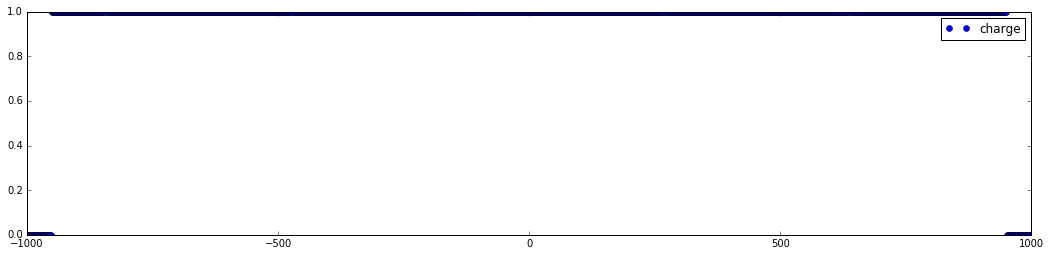

{'label': 'Voltage', 'ls': 'none', 'marker': 'o'}


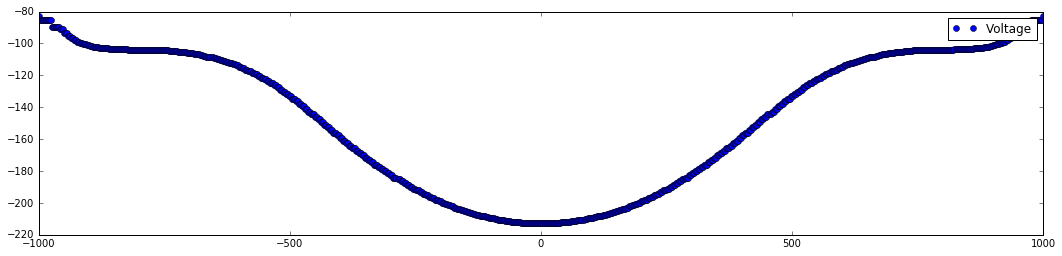

In [13]:
fffcharge = system_eq_obj.plot_cut_1d([1], plot_type='charge', bbox=[(-1000, 1000, 1000)])
fffvolt = system_eq_obj.plot_cut_1d([1], plot_type='voltage', bbox=[(-1000, 1000, 1000)])

f, ax = plt.subplots(1, figsize=(18, 4))
fffcharge([-5], ax, ls='none', marker='o', label='charge')
plt.legend()
plt.show()

f, ax = plt.subplots(1, figsize=(18, 4))
fffvolt([-5], ax, ls='none', marker='o', label='Voltage')
plt.legend()
plt.show()

# Compare with fenics

In [14]:
import pickle

directory = ''

paramsfile = (directory + 'full_orbital_params_gash1e-08geomchris'
                       + 'refine3Nmesh350Nkwant301a_poisson8e-09Lz1.25a_kwant6.3122923588e-09.p')
params = pickle.load(open(paramsfile, 'rb'))
eps_r = 12
units = self_consistency.Unit_converter(params['a_kwant'], params['a_poisson'], eps_r, mstar_over_me)

Cq = pickle.load(open(directory + 'smooth_35_10_full_orbital_capa_gash1e-08'
                      + 'geomchrisrefine3Nmesh350Nkwant301a_poisson8e-09Lz1.25'
                      + 'a_kwant6.3122923588e-09.p', 'rb'), encoding='latin1')

Gq = pickle.load(open(directory + 'full_orbital_green_gash1e-08geomchrisrefine'
                      + '3Nmesh350Nkwant301a_poisson8e-09Lz1.25a_kwant6.31229'
                      + '23588e-09.p', 'rb'), encoding='latin1') * units.Gbar_to_Gq(1)

inex = np.array([233, 102, 204,  65, 298,   6,   2, 184, 109, 281, 222,  91,  13,
       197, 192, 203, 130, 297,  98, 267,  39, 213,  55, 221, 160, 180,
       276, 134,  70, 232,  83, 245, 188,  38, 143,   1,  95, 261, 255,
       116, 207,  69, 174,  23, 271, 129, 283, 142,  79, 240,  31,  54,
       291, 159, 152,   7, 101, 270,  63, 226, 169, 187, 182,  30, 278,
       138,  90, 254, 195,  48,  41,  62, 294, 168, 264, 123,  58,  78,
        72, 234, 178, 194, 288, 151,  85, 249,  96, 263, 199,  57, 162,
        14, 106, 277, 273, 131,  68,  84, 189,  40, 286, 148, 292, 161,
        93, 259,  51,  71, 299, 177, 171,  21, 111, 285,  81, 242, 186,
        36, 196,  50, 290, 157, 251, 272, 205,  67,  59,  80,   4, 185,
       280, 139,  77,  92,  87, 250, 193,  46, 296, 170,  99, 269, 260,
       279, 210,  76, 179,  28, 119, 103, 128, 295, 229, 247,  37, 212,
       145,   3, 158,  11, 257, 118, 217,  86, 175,  25,  19, 200, 284,
       144, 239, 107,  33, 209,  47, 216, 154,   9, 113, 127,  64, 228,
       224,  94, 183,  32, 137, 300, 236, 256, 248, 112,  43, 214, 167,
        18, 266, 124, 121, 136,  73, 235,  27, 206, 133, 153, 147,   5,
       244, 265,  56, 223, 164,  15, 176,  26, 274, 132, 231, 100, 190,
        42,  35, 211, 141, 163, 258, 120,  53, 220,  66, 230, 173,  22,
       126, 146,  82, 243, 238, 105, 198,  52, 156,  10, 253, 115, 268,
       125,  61, 225,  17,  34, 282, 140, 135, 155,  89, 252,  45, 215,
       150, 172, 166,  16, 262, 122,  75, 237, 181,  29,  24,  44, 287,
       149, 246, 110, 202,  60, 208,  74,   0,  12, 117, 289, 219,  88,
       227,  97,  20, 201, 293, 165, 241, 108, 104, 275,  49, 218,   8,
       191, 114])

sites = np.arange(-150, 151) * params['a_kwant'] * 1.e9

1.06250253804e-10


# Epsr Mixed solver = 1

### Charge

In [93]:
%%capture
V = np.eye(301)[151]

#V = np.concatenate([np.ones(int(len(sites)/4)), np.zeros(len(sites) - int(len(sites)/4))]) * 1
V = 1/(np.exp((np.linspace(-150, 150, 301) - 80) / 10) + 1)
V += 1/(np.exp((np.linspace(-150, 150, 301) - 80) / 10) + 1)[::-1]
V = -V + 1.2

#V = 0.01 * np.ones(len(sites))  # in volt
Vg = 0  # in volt

Vq = units.U_to_Uq(V - Vg * np.ones(len(sites)))
grid, ots, qs, g1s, g2s, ks, epsr = make_grid(epsr=12)
discretized_obj, ksites = prepare_solver(grid, ots, qs, g1s, g2s, ks, eps_r)
system_eq_obj = LinearProblem(discretized_obj, 
                              is_charge_density=False,
                              voltage_val = [(g1s + g2s, Vg)], 
                              pos_voltage_mixed=ksites, mixed_val=[(ksites, V)]);

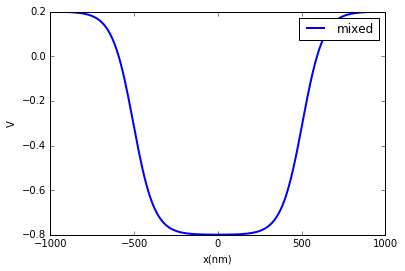

In [94]:
plt.plot(sites, system_eq_obj.points_voltage[ksites] , 'b-', label='mixed', lw=2)

plt.legend()
plt.xlabel('x(nm)')
plt.ylabel('V')

plt.show()


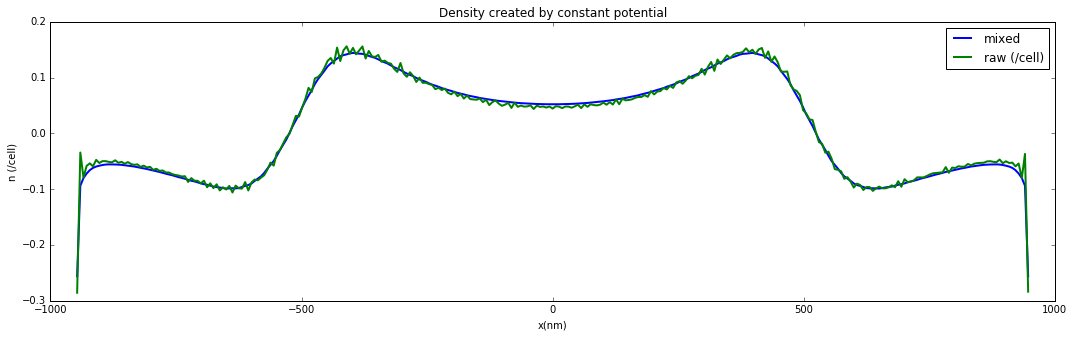

In [98]:
f, ax = plt.subplots(1, figsize=(18, 5))
plt.title('Density created by constant potential')
plt.plot(sites, system_eq_obj.points_charge[ksites] / (nm)**3 * nm / (units.aq / nm * 10) * 10,        
         'b-', label='mixed', lw=2)
plt.plot(sites, units.nq_to_n(1) * np.linalg.inv(Gq).dot(Vq), '-g', lw=2, label='raw (/cell)')
plt.legend()
plt.xlabel('x(nm)')
plt.ylabel('n (m^-2)')
plt.show()


f, ax = plt.subplots(1, figsize=(18, 5))
plt.title('Density created by constant potential')
plt.plot(sites, system_eq_obj.points_charge[ksites] / (nm)**3 * nm / (units.aq / nm * 10) * 10 * (units.aq**2),        
         'b-', label='mixed', lw=2)
plt.plot(sites, np.linalg.inv(Gq).dot(Vq), '-g', lw=2, label='raw (/cell)')
plt.legend()
plt.xlabel('x(nm)')
plt.ylabel('n (/cell)')
plt.show()

### Density

In [100]:
%%capture

#nq = np.eye(301)[151]
nq = np.concatenate([np.ones(int(len(sites)/2)), np.zeros(len(sites) - int(len(sites)/2))])
#nq = 1 * np.ones(len(sites))

n = nq / units.aq * nm
rho = nq / (10 * nm * units.aq**2)
rhotilde = rho * nm**3

Vg = 0
grid, ots, qs, g1s, g2s, ks, epsr = make_grid(epsr=eps_r)
discretized_obj, ksites = prepare_solver(grid, ots, qs, g1s, g2s, ks, epsr)
system_eq_obj = LinearProblem(discretized_obj, 
                              is_charge_density=True,
                              voltage_val = [(g1s + g2s, Vg)], 
                              pos_charge_mixed=ksites, mixed_val=[(ksites, rhotilde)])
                                                                  
system_eq_obj2 = LinearProblem(discretized_obj, 
                              is_charge_density=False,
                              voltage_val = [(g1s + g2s, Vg)], 
                              pos_charge_mixed=ksites, mixed_val=[(ksites, n)])

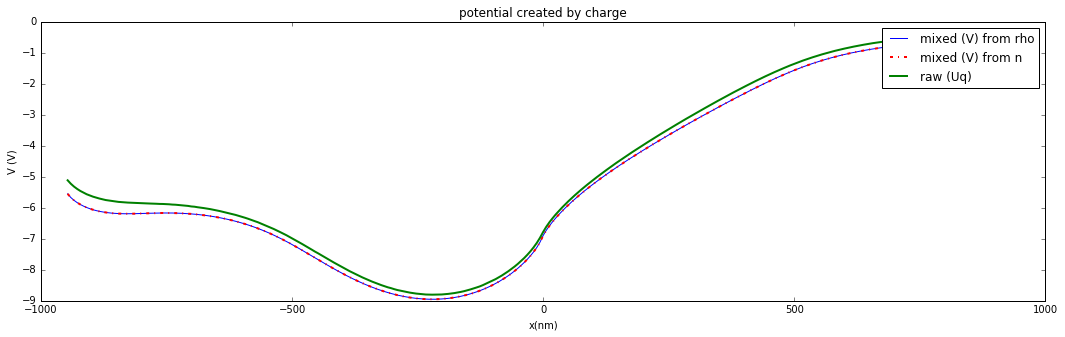

In [101]:
f, ax = plt.subplots(1, figsize=(18, 5))
plt.title('potential created by charge')
plt.plot(sites, system_eq_obj.points_voltage[ksites], 'b-', label='mixed (V) from rho')
plt.plot(sites, system_eq_obj2.points_voltage[ksites], 'r-.', label='mixed (V) from n', lw=2)
plt.plot(sites, Vg + units.Uq_to_U(Gq.dot(nq)), '-g', lw=2, label='raw (Uq)')

plt.xlim(-1000, 1000)
plt.xlabel('x(nm)')
plt.ylabel('V (V)')
plt.legend()
plt.show()